In [1]:
import sys
import os
sys.path.append('..')
sys.path.append('../failure_directions')
import torch
import torchvision
import failure_directions
import numpy as np
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt


import failure_directions.src.svm_utils as svm_utils
import failure_directions.src.visualization_utils as viz_utils
import failure_directions.src.ds_utils as ds_utils
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from failure_directions.src.label_maps import CLASS_DICT
import pickle as pkl
from torchvision.datasets.folder import pil_loader

cifar_label_list = np.array([CLASS_DICT['CIFAR'][u] for u in range(10)])
print(cifar_label_list)

/mnt/cfs/home/saachij/conda_envs/ffcv_cfs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [1]:
sns.set()
BLUE = sns.color_palette("tab10")[0]
RED = sns.color_palette("tab10")[3]
ORANGE = sns.color_palette("tab10")[1]
BROWN = sns.color_palette("tab10")[5]
GRAY = sns.color_palette("tab10")[7]
GREEN = sns.color_palette("tab10")[2]

import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'figure.figsize': (5, 3),
         'axes.labelsize': 14,
         'axes.titlesize':16,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
pylab.rcParams.update(params)


NameError: name 'sns' is not defined

In [3]:
#Load SVM Model
beton_root = "/mnt/cfs/projects/correlated_errors/betons"
experiment_root = "/mnt/cfs/projects/correlated_errors/experiments/cifar/cifar_0.25"

svm_name = "svm_cifar_0.25_unlabeled_normalized"
name = os.path.join(experiment_root, f"svm_checkpoints/{svm_name}.pt") # SVM output file
svm_model_name = os.path.join(experiment_root, f"svm_checkpoints/{svm_name}_model.pkl") # SVM output file
model_root = os.path.join(experiment_root, "models")
model_ckpt = os.path.join(model_root, "cifar10_0.25_unlabeled/version_0/checkpoints/checkpoint_last.pt")
loss_upweight_root = os.path.join(experiment_root, "loss_vec_files")
subset_root = os.path.join(experiment_root, "subset_index_files")

%cd ../failure_directions
processor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, get_unlabeled=True)
%cd ../analysis_nbs
svm_model = processor._build_model(model_ckpt)


/mnt/cfs/home/saachij/src/failure-directions/failure_directions
-----------train_metrics--------------
{'Confusion Matrix': array([[ 439,  192],
       [3195, 6174]]),
 'Model Accuracy': 0.9369,
 'SVM Accuracy': 0.661300003528595,
 'SVM Balanced Accuracy': 0.6773514151573181}
-----------val_metrics--------------
{'Confusion Matrix': array([[1593,  415],
       [1713, 6279]]),
 'Model Accuracy': 0.7992,
 'SVM Accuracy': 0.7871999740600586,
 'SVM Balanced Accuracy': 0.7894936800003052}
-----------test_metrics--------------
{'Confusion Matrix': array([[1346,  749],
       [2007, 5898]]),
 'Model Accuracy': 0.7905,
 'SVM Accuracy': 0.724399983882904,
 'SVM Balanced Accuracy': 0.6942960917949677}
-----------unlabeled_metrics--------------
{'Confusion Matrix': array([[ 3972,  2185],
       [ 5945, 17898]]),
 'Model Accuracy': 0.7947666666666666,
 'SVM Accuracy': 0.7289999723434448,
 'SVM Balanced Accuracy': 0.6978899836540222}
Using default os_cache: False
Using default quasi_random: True
Us

100%|██████████| 100/100 [00:04<00:00, 24.44it/s]


Accuracy 0.9501000046730042


100%|██████████| 100/100 [00:01<00:00, 74.73it/s]


Accuracy 0.7991999983787537


100%|██████████| 100/100 [00:01<00:00, 56.47it/s]


Accuracy 0.7904999852180481


100%|██████████| 300/300 [00:02<00:00, 145.67it/s]


Accuracy 0.7947999835014343
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs
{'training_args': {'epochs': 35, 'lr': 0.5, 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005}, 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}, 'iters_per_epoch': 19}, 'epoch': 34, 'training_metrics': {'loss': 0.17487808826722598, 'acc': 0.9425370065789473}, 'val_metrics': {'loss': 0.6609623561382294, 'acc': 0.7992000002861023}}


In [4]:
processor.metrics['cv_scores']

[0.6642218046323067,
 0.7010094305812045,
 0.6696851119624674,
 0.6415698284604889,
 0.6484821828610479,
 0.6876278118609407,
 0.6769806482669898,
 0.6935678717699402,
 0.6241176656968883,
 0.6601421725872243]

In [5]:
split = 'test'
test_dv = processor.metrics[f'{split}_metrics']['decision_values']
test_confs = processor.run_dict[split]['confs']
test_class = processor.metrics[f'{split}_metrics']['classes'] # 0 if female, 1 if male
test_pred_correct = processor.metrics[f'{split}_metrics']['ypred']
test_correct = processor.metrics[f'{split}_metrics']['ytrue']

In [6]:
from failure_directions.src.config_parsing import ffcv_read_check_override_config
import yaml
%cd ../failure_directions
with open(processor.metrics['args']['config'], 'r') as file:
    fresh_hparams = yaml.safe_load(file)
fresh_hparams = ffcv_read_check_override_config(fresh_hparams)
%cd ../analysis_nbs


/mnt/cfs/home/saachij/src/failure-directions/failure_directions
Using default os_cache: False
Using default quasi_random: True
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default val_beton: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: False
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs


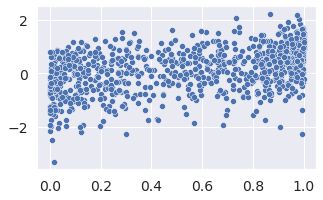

---- CONFIDENCE ------


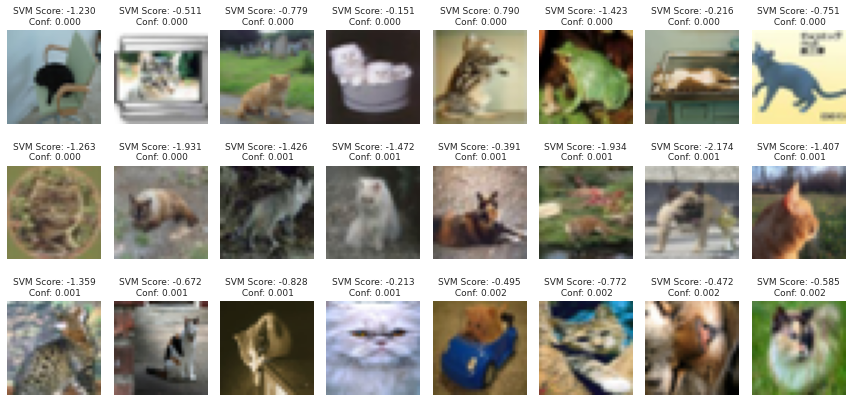

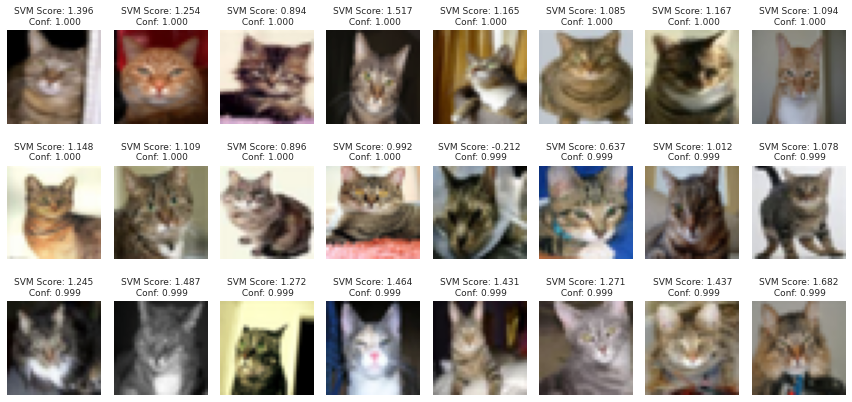

---- SVM ------


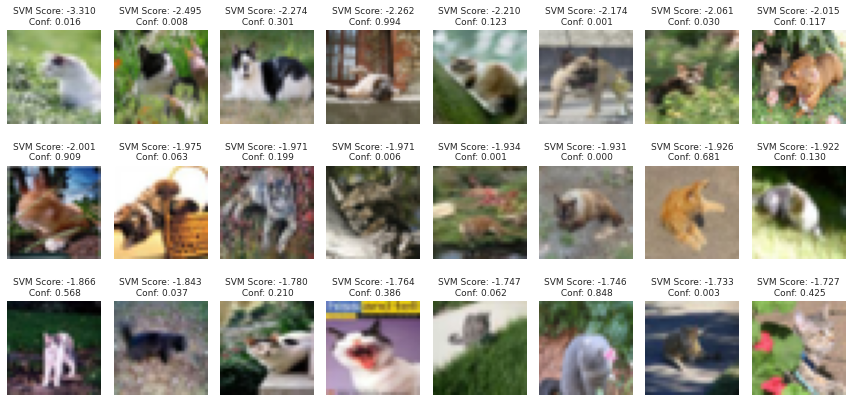

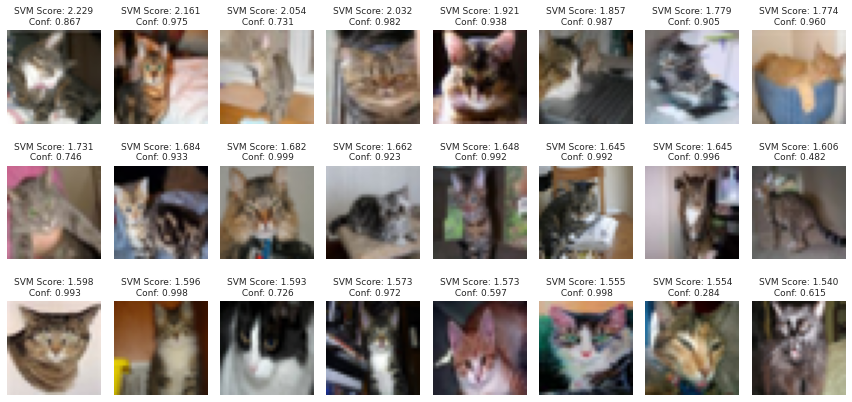

In [8]:
processor.display_extremes(3, split='test', columns=8, rows=3, filename=None)

## Get SVM Directions

In [7]:
# Get big CLIP features
hparams = processor.hparams
clip_processor = failure_directions.CLIPProcessor(ds_mean=hparams['mean'], ds_std=hparams['std'], arch='ViT-L/14')
clip_features = {}
for split, loader in processor.loaders.items():
    clip_features[split] = clip_processor.evaluate_clip_images(loader)

100%|██████████| 300/300 [01:38<00:00,  3.06it/s]


In [8]:
# svm_fitter = failure_directions.SVMFitter()
# svm_fitter.set_preprocess()
# val_gts, val_preds = processor.run_dict['val']['ys'], processor.run_dict['val']['preds']
# cv_scores = svm_fitter.fit(preds=val_preds, ys=val_gts, latents=clip_features['val'])

svm_fitter = failure_directions.SVMFitter()
svm_fitter.import_model("cifar_vit_L_svm.pt")

test_ys = processor.run_dict['test']['ys']
test_latents = clip_features['test']
big_clip_dv = svm_fitter.predict(ys=test_ys, latents=test_latents, compute_metrics=False)[1]

/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


In [ ]:
import os
os.makedirs("cifar_large_directions")
for i in range(10):
    d = svm_fitter.clfs[i].coef_.squeeze(0)
    np.save(f"cifar_large_directions/dir{i}.npy", d/np.linalg.norm(d))

In [ ]:
from failure_directions.src.clip_utils import get_caption_set
captions = failure_directions.get_caption_set('CIFAR')
ref_captions = clip_processor.evaluate_clip_captions(captions['reference'])
np.save("cifar_large_directions/ref_captions.npy", ref_captions.numpy())

## Read the generated images

In [7]:
import src.stable_diffusion_utils as sd_utils
from src.stable_diffusion_utils import DiffDataset

In [8]:
images_path = "/mnt/cfs/home/saachij/src/stable-diffusion/slerp_images"

In [9]:
path_dict = sd_utils.get_path_dict(images_path, num_classes=10)
print(len(path_dict[0]['flip'][0]))

150


In [10]:
import torchvision.transforms as transforms
import torchvision
from failure_directions.src.decoders_and_transforms import PyTranslate, PyCutOut
hparams = processor.hparams

fill_color = tuple(map(int, hparams['mean']))

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=np.array(hparams['mean'])/255, std=np.array(hparams['std'])/255)])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    PyTranslate(2),
    PyCutOut(4, fill_color),
    base_transform
])

# For visualization
INV_NORM = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [255/x for x in hparams['std']]),
                                transforms.Normalize(mean = [-x /255 for x in hparams['mean']],
                                                     std = [ 1., 1., 1. ])])
TOIMAGE = transforms.Compose([INV_NORM, transforms.ToPILImage()])
resize_base_transform = transforms.Compose([base_transform, transforms.Resize((32, 32))])
resize_train_transform = transforms.Compose([train_transform, transforms.Resize((32, 32))])

In [11]:
def evaluate_model(model, loader):
    with torch.no_grad():
        with autocast():
            gts, preds, confs = [], [], []
            for x, y in tqdm(loader):
                x = x.cuda()
                logits = model(x)
                gts.append(y.cpu())
                preds.append(logits.argmax(-1).cpu())
                softmax_logits = nn.Softmax(dim=-1)(logits)
                confs.append(softmax_logits[torch.arange(logits.shape[0]), y].cpu())
    gts = torch.cat(gts)
    preds = torch.cat(preds)
    confs = torch.cat(confs)
    return gts, preds, confs

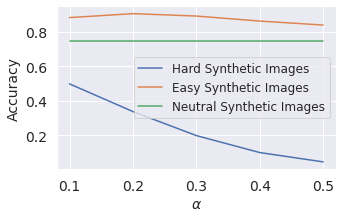

In [14]:
# # See relative accuracies
# def get_diff_predictions(flip_name, intensity,target_class=None):
#     base_ds = DiffDataset(path_dict, flip_name=flip_name, intensity=intensity, transform=resize_base_transform, num_imgs_per_class=100)
#     base_loader = torch.utils.data.DataLoader(base_ds, batch_size=100, shuffle=False, drop_last=False)
#     gts, preds, confs = evaluate_model(svm_model, base_loader)
#     if target_class is not None:
#         mask = gts == target_class
#         gts, preds, confs = gts[mask], preds[mask], confs[mask]
#     return gts, preds, confs, (gts==preds).float().mean().item()

# intensities = [0.1, 0.2, 0.3, 0.4, 0.5]
# base_acc = get_diff_predictions(flip_name="flip", intensity=0)[3]
# flip_accs = [get_diff_predictions(flip_name="flip", intensity=u)[3] for u in intensities]
# no_flip_accs = [get_diff_predictions(flip_name="no_flip", intensity=u)[3] for u in intensities]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.lineplot(x=intensities, y=flip_accs, label='Hard Synthetic Images', ax=ax)
sns.lineplot(x=intensities, y=no_flip_accs, label='Easy Synthetic Images', ax=ax)
sns.lineplot(x=intensities, y=[base_acc]*len(intensities), label='Neutral Synthetic Images', ax=ax)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel("Accuracy")
plt.savefig("synthetic_images.pdf", bbox_inches='tight')
plt.show()

# base_accs = []
# orig_accs = []
# flip_accs = []
# for c in range(10):
#     base_acc = get_diff_predictions(flip_name="flip", intensity=0, target_class=c)[3]
#     orig_acc = (test_correct[test_class == c]).mean()
#     flip_acc = get_diff_predictions(flip_name="flip", intensity=0.2, target_class=c)[3]
#     print(c, base_acc, flip_acc, orig_acc)
#     base_accs.append(base_acc)
#     orig_accs.append(orig_acc)
#     flip_accs.append(flip_acc)


In [28]:
print(*zip(np.arange(10), cifar_label_list))

(0, 'airplane') (1, 'automobile') (2, 'bird') (3, 'cat') (4, 'deer') (5, 'dog') (6, 'frog') (7, 'horse') (8, 'ship') (9, 'truck')


# Train models

In [36]:
bsz = fresh_hparams['batch_size']
ds_root = "/mnt/cfs/datasets/cifar"
orig_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=base_transform)
aug_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=train_transform)
test_ds = torchvision.datasets.CIFAR10(ds_root, train=False, transform=base_transform)

val_indices = processor.indices_dict['val_indices']
train_indices = processor.indices_dict['train_indices']

train_ds = torch.utils.data.Subset(aug_train_ds, train_indices)
val_ds = torch.utils.data.Subset(orig_train_ds, val_indices)
no_aug_train_ds = torch.utils.data.Subset(orig_train_ds, train_indices)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=True, drop_last=True)
no_shuffle_train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=bsz, shuffle=False, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bsz, shuffle=False, drop_last=False)
no_aug_train_loader = torch.utils.data.DataLoader(no_aug_train_ds, batch_size=bsz, shuffle=False, drop_last=False)



In [37]:
import copy

def run_model(train_loader_, val_loader_, test_loader_, set_device=False):
    build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
    model = build_fn(hparams['arch'], hparams['num_classes'])
    model = model.cuda()

    training_args=hparams['training']
    training_args['iters_per_epoch'] = len(train_loader_)
    trainer = failure_directions.LightWeightTrainer(training_args=training_args,
                                                    exp_name='temp', enable_logging=False,
                                                    bce=False, set_device=set_device)
    trainer.fit(model, train_loader_, val_loader_)
    return evaluate_model(model, test_loader_)

def run_finetune_model(train_loader_, val_loader_, test_loader_, set_device=False, freeze=True):
    finetune_training = {
     'epochs': 15,
     'lr': 0.1,
     'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005},
     'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}
    }
    
    build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
    model = copy.deepcopy(svm_model).train()
    
    if freeze:
        for name, p in model.named_parameters():
            if name.split('.')[0] != 'linear':
                print("freezing", name)
                p.requires_grad = False


    training_args=finetune_training
    training_args['iters_per_epoch'] = len(train_loader_)
    trainer = failure_directions.LightWeightTrainer(training_args=training_args,
                                                    exp_name='temp', enable_logging=False,
                                                    bce=False, set_device=set_device)
    trainer.fit(model, train_loader_, val_loader_)
    return evaluate_model(model, test_loader_)

In [44]:
# See relative accuracies
#4
flip_interventions = {}
for intensity in [0, 0.1, 0.2]:
    flip_interventions[intensity] = []
    for v in range(5):
        base_synth_dataset = DiffDataset(path_dict, flip_name='flip', intensity=intensity, num_imgs_per_class=150,
                                         transform=resize_train_transform, include_classes=[3])
        synth_train_set = torch.utils.data.ConcatDataset([train_ds, base_synth_dataset])
        synth_train_loader = torch.utils.data.DataLoader(synth_train_set, batch_size=bsz, shuffle=True, drop_last=True)
        flip_interventions[intensity].append(run_finetune_model(synth_train_loader, val_loader, test_loader, set_device=True, freeze=False))

flip_int_corrects = {}
for intensity in flip_interventions:
    arr = flip_interventions[intensity]
    flip_int_corrects[intensity] = [arr[v][0] ==  arr[v][1] for v in range(len(arr))]

Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.71it/s, loss=0.419, acc=0.871]


LR: 0.02, Train Loss: 0.2083, Train Acc: 0.9293, Val Loss: 0.7089, Val Acc: 0.7878


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.418, acc=0.864]


LR: 0.04, Train Loss: 0.1932, Train Acc: 0.9324, Val Loss: 0.6944, Val Acc: 0.7950


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.646, acc=0.82] 


LR: 0.06, Train Loss: 0.1974, Train Acc: 0.9313, Val Loss: 0.8144, Val Acc: 0.7712


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.6, acc=0.827]  


LR: 0.08, Train Loss: 0.2069, Train Acc: 0.9285, Val Loss: 0.8092, Val Acc: 0.7645


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.819, acc=0.783]


LR: 0.1, Train Loss: 0.2499, Train Acc: 0.9107, Val Loss: 1.2757, Val Acc: 0.6835


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.866, acc=0.754]


LR: 0.09000000000000001, Train Loss: 0.2916, Train Acc: 0.8938, Val Loss: 0.8768, Val Acc: 0.7547


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.38it/s, loss=0.803, acc=0.776]


LR: 0.08000000000000002, Train Loss: 0.2418, Train Acc: 0.9124, Val Loss: 0.8699, Val Acc: 0.7463


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.69it/s, loss=0.545, acc=0.838]


LR: 0.06999999999999999, Train Loss: 0.2032, Train Acc: 0.9295, Val Loss: 0.7721, Val Acc: 0.7735


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.29, acc=0.912] 


LR: 0.06000000000000001, Train Loss: 0.1602, Train Acc: 0.9457, Val Loss: 0.7892, Val Acc: 0.7797


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.496, acc=0.864]


LR: 0.05, Train Loss: 0.1419, Train Acc: 0.9532, Val Loss: 0.7660, Val Acc: 0.7886


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.371, acc=0.886]


LR: 0.04000000000000001, Train Loss: 0.1159, Train Acc: 0.9634, Val Loss: 0.7494, Val Acc: 0.7917


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=0.476, acc=0.871]


LR: 0.030000000000000006, Train Loss: 0.0985, Train Acc: 0.9692, Val Loss: 0.7457, Val Acc: 0.7963


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.517, acc=0.849]


LR: 0.020000000000000007, Train Loss: 0.0774, Train Acc: 0.9780, Val Loss: 0.7370, Val Acc: 0.7975


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.422, acc=0.875]


LR: 0.009999999999999998, Train Loss: 0.0627, Train Acc: 0.9822, Val Loss: 0.7175, Val Acc: 0.8033


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s, loss=0.412, acc=0.879]


LR: 0.0, Train Loss: 0.0535, Train Acc: 0.9853, Val Loss: 0.7212, Val Acc: 0.8051


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=0.471, acc=0.875]


LR: 0.02, Train Loss: 0.2047, Train Acc: 0.9292, Val Loss: 0.7222, Val Acc: 0.7848


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=0.53, acc=0.842] 


LR: 0.04, Train Loss: 0.1881, Train Acc: 0.9359, Val Loss: 0.7409, Val Acc: 0.7834


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.531, acc=0.842]


LR: 0.06, Train Loss: 0.1946, Train Acc: 0.9330, Val Loss: 0.7616, Val Acc: 0.7756


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.377, acc=0.89] 


LR: 0.08, Train Loss: 0.2146, Train Acc: 0.9259, Val Loss: 0.8652, Val Acc: 0.7620


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=0.619, acc=0.812]


LR: 0.1, Train Loss: 0.2766, Train Acc: 0.9008, Val Loss: 0.9149, Val Acc: 0.7423


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.593, acc=0.853]


LR: 0.09000000000000001, Train Loss: 0.3031, Train Acc: 0.8881, Val Loss: 0.9621, Val Acc: 0.7348


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.482, acc=0.868]


LR: 0.08000000000000002, Train Loss: 0.2562, Train Acc: 0.9083, Val Loss: 0.8633, Val Acc: 0.7511


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.485, acc=0.864]


LR: 0.06999999999999999, Train Loss: 0.2079, Train Acc: 0.9273, Val Loss: 0.7484, Val Acc: 0.7750


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.662, acc=0.805]


LR: 0.06000000000000001, Train Loss: 0.1589, Train Acc: 0.9474, Val Loss: 0.7571, Val Acc: 0.7786


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=0.516, acc=0.853]


LR: 0.05, Train Loss: 0.1399, Train Acc: 0.9535, Val Loss: 0.7404, Val Acc: 0.7915


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=0.519, acc=0.846]


LR: 0.04000000000000001, Train Loss: 0.1137, Train Acc: 0.9621, Val Loss: 0.7465, Val Acc: 0.7925


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=0.437, acc=0.879]


LR: 0.030000000000000006, Train Loss: 0.0898, Train Acc: 0.9708, Val Loss: 0.7526, Val Acc: 0.7992


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.37, acc=0.901] 


LR: 0.020000000000000007, Train Loss: 0.0774, Train Acc: 0.9764, Val Loss: 0.7142, Val Acc: 0.8051


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.356, acc=0.904]


LR: 0.009999999999999998, Train Loss: 0.0636, Train Acc: 0.9830, Val Loss: 0.7064, Val Acc: 0.8074


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.421, acc=0.879]


LR: 0.0, Train Loss: 0.0540, Train Acc: 0.9868, Val Loss: 0.7075, Val Acc: 0.8084


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.466, acc=0.871]


LR: 0.02, Train Loss: 0.2070, Train Acc: 0.9327, Val Loss: 0.7201, Val Acc: 0.7863


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.386, acc=0.875]


LR: 0.04, Train Loss: 0.1922, Train Acc: 0.9336, Val Loss: 0.6862, Val Acc: 0.7957


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.497, acc=0.842]


LR: 0.06, Train Loss: 0.1830, Train Acc: 0.9367, Val Loss: 0.7928, Val Acc: 0.7698


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=0.434, acc=0.871]


LR: 0.08, Train Loss: 0.2098, Train Acc: 0.9230, Val Loss: 0.8532, Val Acc: 0.7514


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.384, acc=0.919]


LR: 0.1, Train Loss: 0.2475, Train Acc: 0.9118, Val Loss: 1.0261, Val Acc: 0.7280


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.55, acc=0.849] 


LR: 0.09000000000000001, Train Loss: 0.2802, Train Acc: 0.8973, Val Loss: 0.9553, Val Acc: 0.7314


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.872, acc=0.75] 


LR: 0.08000000000000002, Train Loss: 0.2506, Train Acc: 0.9093, Val Loss: 0.7901, Val Acc: 0.7692


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=0.213, acc=0.912]


LR: 0.06999999999999999, Train Loss: 0.1969, Train Acc: 0.9308, Val Loss: 0.7635, Val Acc: 0.7694


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=0.389, acc=0.897]


LR: 0.06000000000000001, Train Loss: 0.1721, Train Acc: 0.9399, Val Loss: 0.8456, Val Acc: 0.7652


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.361, acc=0.901]


LR: 0.05, Train Loss: 0.1455, Train Acc: 0.9511, Val Loss: 0.7577, Val Acc: 0.7853


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=0.426, acc=0.886]


LR: 0.04000000000000001, Train Loss: 0.1155, Train Acc: 0.9634, Val Loss: 0.7377, Val Acc: 0.7955


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.45, acc=0.871] 


LR: 0.030000000000000006, Train Loss: 0.0963, Train Acc: 0.9689, Val Loss: 0.7181, Val Acc: 0.8013


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.467, acc=0.886]


LR: 0.020000000000000007, Train Loss: 0.0717, Train Acc: 0.9789, Val Loss: 0.7413, Val Acc: 0.8017


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=0.459, acc=0.882]


LR: 0.009999999999999998, Train Loss: 0.0623, Train Acc: 0.9830, Val Loss: 0.7296, Val Acc: 0.8019


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=0.409, acc=0.886]


LR: 0.0, Train Loss: 0.0501, Train Acc: 0.9875, Val Loss: 0.7192, Val Acc: 0.8053


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.429, acc=0.886]


LR: 0.02, Train Loss: 0.2069, Train Acc: 0.9291, Val Loss: 0.7129, Val Acc: 0.7896


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=0.55, acc=0.82]  


LR: 0.04, Train Loss: 0.1908, Train Acc: 0.9343, Val Loss: 0.7296, Val Acc: 0.7812


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.349, acc=0.893]


LR: 0.06, Train Loss: 0.1938, Train Acc: 0.9327, Val Loss: 0.8237, Val Acc: 0.7650


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.444, acc=0.868]


LR: 0.08, Train Loss: 0.2184, Train Acc: 0.9214, Val Loss: 0.8277, Val Acc: 0.7636


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.48, acc=0.875] 


LR: 0.1, Train Loss: 0.2445, Train Acc: 0.9126, Val Loss: 0.8480, Val Acc: 0.7577


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s, loss=0.57, acc=0.857] 


LR: 0.09000000000000001, Train Loss: 0.2858, Train Acc: 0.8990, Val Loss: 0.7751, Val Acc: 0.7669


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=0.609, acc=0.831]


LR: 0.08000000000000002, Train Loss: 0.2585, Train Acc: 0.9043, Val Loss: 0.9056, Val Acc: 0.7352


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.438, acc=0.879]


LR: 0.06999999999999999, Train Loss: 0.2075, Train Acc: 0.9292, Val Loss: 0.7575, Val Acc: 0.7771


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=0.464, acc=0.864]


LR: 0.06000000000000001, Train Loss: 0.1721, Train Acc: 0.9417, Val Loss: 0.8077, Val Acc: 0.7678


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.55, acc=0.86]  


LR: 0.05, Train Loss: 0.1360, Train Acc: 0.9571, Val Loss: 0.7553, Val Acc: 0.7855


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s, loss=0.472, acc=0.868]


LR: 0.04000000000000001, Train Loss: 0.1132, Train Acc: 0.9642, Val Loss: 0.7772, Val Acc: 0.7866


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s, loss=0.421, acc=0.875]


LR: 0.030000000000000006, Train Loss: 0.0903, Train Acc: 0.9747, Val Loss: 0.7243, Val Acc: 0.8001


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.472, acc=0.882]


LR: 0.020000000000000007, Train Loss: 0.0721, Train Acc: 0.9780, Val Loss: 0.7409, Val Acc: 0.8019


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.457, acc=0.875]


LR: 0.009999999999999998, Train Loss: 0.0641, Train Acc: 0.9830, Val Loss: 0.7287, Val Acc: 0.8050


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=0.383, acc=0.882]


LR: 0.0, Train Loss: 0.0518, Train Acc: 0.9866, Val Loss: 0.7184, Val Acc: 0.8090


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.419, acc=0.89] 


LR: 0.02, Train Loss: 0.2008, Train Acc: 0.9326, Val Loss: 0.7022, Val Acc: 0.7906


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=0.32, acc=0.908] 


LR: 0.04, Train Loss: 0.1911, Train Acc: 0.9358, Val Loss: 0.7042, Val Acc: 0.7887


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=0.661, acc=0.79] 


LR: 0.06, Train Loss: 0.1875, Train Acc: 0.9353, Val Loss: 0.7789, Val Acc: 0.7708


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.248, acc=0.938]


LR: 0.08, Train Loss: 0.2099, Train Acc: 0.9273, Val Loss: 0.8550, Val Acc: 0.7693


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=1, acc=0.743]    


LR: 0.1, Train Loss: 0.2478, Train Acc: 0.9125, Val Loss: 1.0048, Val Acc: 0.7368


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=0.542, acc=0.853]


LR: 0.09000000000000001, Train Loss: 0.2715, Train Acc: 0.9024, Val Loss: 0.8519, Val Acc: 0.7574


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=1.04, acc=0.721] 


LR: 0.08000000000000002, Train Loss: 0.2389, Train Acc: 0.9157, Val Loss: 0.8799, Val Acc: 0.7540


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.285, acc=0.908]


LR: 0.06999999999999999, Train Loss: 0.2230, Train Acc: 0.9222, Val Loss: 0.8693, Val Acc: 0.7515


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.407, acc=0.882]


LR: 0.06000000000000001, Train Loss: 0.1786, Train Acc: 0.9384, Val Loss: 0.7696, Val Acc: 0.7798


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=0.328, acc=0.904]


LR: 0.05, Train Loss: 0.1425, Train Acc: 0.9531, Val Loss: 0.7375, Val Acc: 0.7880


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=0.608, acc=0.827]


LR: 0.04000000000000001, Train Loss: 0.1070, Train Acc: 0.9653, Val Loss: 0.7448, Val Acc: 0.7941


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.435, acc=0.868]


LR: 0.030000000000000006, Train Loss: 0.0875, Train Acc: 0.9749, Val Loss: 0.7200, Val Acc: 0.7985


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.348, acc=0.897]


LR: 0.020000000000000007, Train Loss: 0.0682, Train Acc: 0.9809, Val Loss: 0.7215, Val Acc: 0.8033


Val Epoch: 13: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s, loss=0.308, acc=0.893]


LR: 0.009999999999999998, Train Loss: 0.0600, Train Acc: 0.9829, Val Loss: 0.7103, Val Acc: 0.8081


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.344, acc=0.886]


LR: 0.0, Train Loss: 0.0529, Train Acc: 0.9862, Val Loss: 0.7147, Val Acc: 0.8087


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.445, acc=0.886]


LR: 0.02, Train Loss: 0.2379, Train Acc: 0.9189, Val Loss: 0.7563, Val Acc: 0.7779


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.368, acc=0.886]


LR: 0.04, Train Loss: 0.2008, Train Acc: 0.9287, Val Loss: 0.7298, Val Acc: 0.7851


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.636, acc=0.79] 


LR: 0.06, Train Loss: 0.1957, Train Acc: 0.9321, Val Loss: 0.7636, Val Acc: 0.7720


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.736, acc=0.801]


LR: 0.08, Train Loss: 0.2090, Train Acc: 0.9248, Val Loss: 0.9017, Val Acc: 0.7566


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.729, acc=0.809]


LR: 0.1, Train Loss: 0.2568, Train Acc: 0.9084, Val Loss: 1.0168, Val Acc: 0.7228


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.69it/s, loss=0.363, acc=0.886]


LR: 0.09000000000000001, Train Loss: 0.2982, Train Acc: 0.8938, Val Loss: 1.0409, Val Acc: 0.7162


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=0.344, acc=0.904]


LR: 0.08000000000000002, Train Loss: 0.2606, Train Acc: 0.9027, Val Loss: 0.7794, Val Acc: 0.7696


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s, loss=0.515, acc=0.853]


LR: 0.06999999999999999, Train Loss: 0.2095, Train Acc: 0.9250, Val Loss: 0.8108, Val Acc: 0.7615


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=0.421, acc=0.882]


LR: 0.06000000000000001, Train Loss: 0.1687, Train Acc: 0.9426, Val Loss: 0.7539, Val Acc: 0.7815


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=0.329, acc=0.893]


LR: 0.05, Train Loss: 0.1381, Train Acc: 0.9556, Val Loss: 0.7560, Val Acc: 0.7861


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.402, acc=0.886]


LR: 0.04000000000000001, Train Loss: 0.1112, Train Acc: 0.9654, Val Loss: 0.7456, Val Acc: 0.7928


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.69it/s, loss=0.411, acc=0.882]


LR: 0.030000000000000006, Train Loss: 0.0887, Train Acc: 0.9716, Val Loss: 0.7777, Val Acc: 0.7893


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.68it/s, loss=0.488, acc=0.868]


LR: 0.020000000000000007, Train Loss: 0.0736, Train Acc: 0.9796, Val Loss: 0.7397, Val Acc: 0.7964


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.69it/s, loss=0.437, acc=0.879]


LR: 0.009999999999999998, Train Loss: 0.0608, Train Acc: 0.9834, Val Loss: 0.7171, Val Acc: 0.8067


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s, loss=0.381, acc=0.893]


LR: 0.0, Train Loss: 0.0501, Train Acc: 0.9877, Val Loss: 0.7084, Val Acc: 0.8083


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=0.366, acc=0.893]


LR: 0.02, Train Loss: 0.2366, Train Acc: 0.9232, Val Loss: 0.7333, Val Acc: 0.7786


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=0.491, acc=0.831]


LR: 0.04, Train Loss: 0.2003, Train Acc: 0.9314, Val Loss: 0.7045, Val Acc: 0.7929


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=0.494, acc=0.835]


LR: 0.06, Train Loss: 0.1919, Train Acc: 0.9327, Val Loss: 0.7814, Val Acc: 0.7765


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.67it/s, loss=0.934, acc=0.75] 


LR: 0.08, Train Loss: 0.2329, Train Acc: 0.9181, Val Loss: 0.9098, Val Acc: 0.7458


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.955, acc=0.695]


LR: 0.1, Train Loss: 0.2562, Train Acc: 0.9100, Val Loss: 0.8819, Val Acc: 0.7457


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.917, acc=0.728]


LR: 0.09000000000000001, Train Loss: 0.2859, Train Acc: 0.8946, Val Loss: 0.9216, Val Acc: 0.7421


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.801, acc=0.754]


LR: 0.08000000000000002, Train Loss: 0.2438, Train Acc: 0.9140, Val Loss: 0.8999, Val Acc: 0.7402


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.424, acc=0.89] 


LR: 0.06999999999999999, Train Loss: 0.2018, Train Acc: 0.9278, Val Loss: 0.8399, Val Acc: 0.7677


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.57, acc=0.838] 


LR: 0.06000000000000001, Train Loss: 0.1671, Train Acc: 0.9436, Val Loss: 0.7621, Val Acc: 0.7802


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.519, acc=0.853]


LR: 0.05, Train Loss: 0.1360, Train Acc: 0.9535, Val Loss: 0.7616, Val Acc: 0.7898


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.35, acc=0.904] 


LR: 0.04000000000000001, Train Loss: 0.1103, Train Acc: 0.9630, Val Loss: 0.7449, Val Acc: 0.7942


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=0.389, acc=0.89] 


LR: 0.030000000000000006, Train Loss: 0.0902, Train Acc: 0.9727, Val Loss: 0.7470, Val Acc: 0.7965


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.525, acc=0.846]


LR: 0.020000000000000007, Train Loss: 0.0712, Train Acc: 0.9804, Val Loss: 0.7435, Val Acc: 0.8002


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.397, acc=0.882]


LR: 0.009999999999999998, Train Loss: 0.0618, Train Acc: 0.9826, Val Loss: 0.7314, Val Acc: 0.8039


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.439, acc=0.879]


LR: 0.0, Train Loss: 0.0509, Train Acc: 0.9880, Val Loss: 0.7211, Val Acc: 0.8068


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.383, acc=0.89] 


LR: 0.02, Train Loss: 0.2390, Train Acc: 0.9226, Val Loss: 0.7333, Val Acc: 0.7799


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=0.327, acc=0.904]


LR: 0.04, Train Loss: 0.1979, Train Acc: 0.9319, Val Loss: 0.7285, Val Acc: 0.7852


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.446, acc=0.86] 


LR: 0.06, Train Loss: 0.1925, Train Acc: 0.9354, Val Loss: 0.7850, Val Acc: 0.7760


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.588, acc=0.842]


LR: 0.08, Train Loss: 0.2064, Train Acc: 0.9279, Val Loss: 0.8178, Val Acc: 0.7727


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.67it/s, loss=0.694, acc=0.824]


LR: 0.1, Train Loss: 0.2638, Train Acc: 0.9028, Val Loss: 1.2389, Val Acc: 0.6936


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.613, acc=0.82] 


LR: 0.09000000000000001, Train Loss: 0.2853, Train Acc: 0.9002, Val Loss: 0.7990, Val Acc: 0.7608


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.428, acc=0.886]


LR: 0.08000000000000002, Train Loss: 0.2652, Train Acc: 0.9058, Val Loss: 0.8407, Val Acc: 0.7582


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.365, acc=0.912]


LR: 0.06999999999999999, Train Loss: 0.2239, Train Acc: 0.9208, Val Loss: 0.8769, Val Acc: 0.7484


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.522, acc=0.838]


LR: 0.06000000000000001, Train Loss: 0.1924, Train Acc: 0.9318, Val Loss: 0.7649, Val Acc: 0.7750


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=0.667, acc=0.824]


LR: 0.05, Train Loss: 0.1530, Train Acc: 0.9508, Val Loss: 0.7748, Val Acc: 0.7770


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.334, acc=0.901]


LR: 0.04000000000000001, Train Loss: 0.1204, Train Acc: 0.9608, Val Loss: 0.7663, Val Acc: 0.7906


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.458, acc=0.882]


LR: 0.030000000000000006, Train Loss: 0.0922, Train Acc: 0.9730, Val Loss: 0.7542, Val Acc: 0.8003


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=0.515, acc=0.846]


LR: 0.020000000000000007, Train Loss: 0.0780, Train Acc: 0.9769, Val Loss: 0.7199, Val Acc: 0.8029


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.334, acc=0.904]


LR: 0.009999999999999998, Train Loss: 0.0596, Train Acc: 0.9848, Val Loss: 0.7115, Val Acc: 0.8084


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.362, acc=0.893]


LR: 0.0, Train Loss: 0.0506, Train Acc: 0.9883, Val Loss: 0.7127, Val Acc: 0.8117


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.431, acc=0.871]


LR: 0.02, Train Loss: 0.2354, Train Acc: 0.9191, Val Loss: 0.7457, Val Acc: 0.7753


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.598, acc=0.805]


LR: 0.04, Train Loss: 0.2047, Train Acc: 0.9310, Val Loss: 0.7325, Val Acc: 0.7856


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.32, acc=0.904] 


LR: 0.06, Train Loss: 0.1959, Train Acc: 0.9280, Val Loss: 0.8099, Val Acc: 0.7723


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.264, acc=0.912]


LR: 0.08, Train Loss: 0.2316, Train Acc: 0.9162, Val Loss: 0.8398, Val Acc: 0.7561


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.934, acc=0.717]


LR: 0.1, Train Loss: 0.2538, Train Acc: 0.9125, Val Loss: 0.9611, Val Acc: 0.7385


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.338, acc=0.901]


LR: 0.09000000000000001, Train Loss: 0.2746, Train Acc: 0.8981, Val Loss: 0.9834, Val Acc: 0.7264


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.538, acc=0.857]


LR: 0.08000000000000002, Train Loss: 0.2526, Train Acc: 0.9084, Val Loss: 0.8584, Val Acc: 0.7596


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.44, acc=0.893] 


LR: 0.06999999999999999, Train Loss: 0.2077, Train Acc: 0.9252, Val Loss: 0.9344, Val Acc: 0.7553


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.369, acc=0.901]


LR: 0.06000000000000001, Train Loss: 0.1731, Train Acc: 0.9421, Val Loss: 0.8869, Val Acc: 0.7621


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.316, acc=0.912]


LR: 0.05, Train Loss: 0.1477, Train Acc: 0.9468, Val Loss: 0.7368, Val Acc: 0.7895


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.671, acc=0.835]


LR: 0.04000000000000001, Train Loss: 0.1298, Train Acc: 0.9549, Val Loss: 0.7603, Val Acc: 0.7925


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.67it/s, loss=0.36, acc=0.901] 


LR: 0.030000000000000006, Train Loss: 0.0907, Train Acc: 0.9732, Val Loss: 0.7270, Val Acc: 0.8031


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.476, acc=0.86] 


LR: 0.020000000000000007, Train Loss: 0.0793, Train Acc: 0.9763, Val Loss: 0.7287, Val Acc: 0.8029


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.383, acc=0.875]


LR: 0.009999999999999998, Train Loss: 0.0594, Train Acc: 0.9847, Val Loss: 0.7227, Val Acc: 0.8040


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.417, acc=0.875]


LR: 0.0, Train Loss: 0.0537, Train Acc: 0.9872, Val Loss: 0.7187, Val Acc: 0.8051


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.33it/s, loss=0.384, acc=0.879]


LR: 0.02, Train Loss: 0.2331, Train Acc: 0.9208, Val Loss: 0.7662, Val Acc: 0.7746


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.539, acc=0.827]


LR: 0.04, Train Loss: 0.1974, Train Acc: 0.9307, Val Loss: 0.7924, Val Acc: 0.7718


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.428, acc=0.893]


LR: 0.06, Train Loss: 0.2029, Train Acc: 0.9311, Val Loss: 0.7907, Val Acc: 0.7724


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s, loss=0.778, acc=0.779]


LR: 0.08, Train Loss: 0.2103, Train Acc: 0.9273, Val Loss: 0.9527, Val Acc: 0.7466


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=0.499, acc=0.875]


LR: 0.1, Train Loss: 0.2618, Train Acc: 0.9048, Val Loss: 0.9815, Val Acc: 0.7276


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s, loss=1.08, acc=0.732] 


LR: 0.09000000000000001, Train Loss: 0.2918, Train Acc: 0.8927, Val Loss: 0.9468, Val Acc: 0.7403


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.971, acc=0.717]


LR: 0.08000000000000002, Train Loss: 0.2539, Train Acc: 0.9089, Val Loss: 0.8857, Val Acc: 0.7491


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=0.307, acc=0.901]


LR: 0.06999999999999999, Train Loss: 0.2060, Train Acc: 0.9276, Val Loss: 0.8175, Val Acc: 0.7634


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s, loss=0.477, acc=0.864]


LR: 0.06000000000000001, Train Loss: 0.1726, Train Acc: 0.9396, Val Loss: 0.7587, Val Acc: 0.7816


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=0.359, acc=0.893]


LR: 0.05, Train Loss: 0.1427, Train Acc: 0.9530, Val Loss: 0.7349, Val Acc: 0.7912


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.592, acc=0.846]


LR: 0.04000000000000001, Train Loss: 0.1192, Train Acc: 0.9621, Val Loss: 0.8501, Val Acc: 0.7671


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=0.421, acc=0.893]


LR: 0.030000000000000006, Train Loss: 0.0947, Train Acc: 0.9700, Val Loss: 0.7345, Val Acc: 0.8012


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.368, acc=0.89] 


LR: 0.020000000000000007, Train Loss: 0.0746, Train Acc: 0.9769, Val Loss: 0.7243, Val Acc: 0.8046


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.451, acc=0.857]


LR: 0.009999999999999998, Train Loss: 0.0635, Train Acc: 0.9821, Val Loss: 0.7184, Val Acc: 0.8069


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.404, acc=0.882]


LR: 0.0, Train Loss: 0.0513, Train Acc: 0.9876, Val Loss: 0.7107, Val Acc: 0.8081


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=0.425, acc=0.875]


LR: 0.02, Train Loss: 0.2299, Train Acc: 0.9240, Val Loss: 0.7535, Val Acc: 0.7707


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.68it/s, loss=0.412, acc=0.897]


LR: 0.04, Train Loss: 0.1966, Train Acc: 0.9336, Val Loss: 0.7350, Val Acc: 0.7847


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.259, acc=0.941]


LR: 0.06, Train Loss: 0.1917, Train Acc: 0.9367, Val Loss: 0.8261, Val Acc: 0.7652


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.45it/s, loss=0.353, acc=0.882]


LR: 0.08, Train Loss: 0.2113, Train Acc: 0.9245, Val Loss: 0.8388, Val Acc: 0.7665


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.356, acc=0.915]


LR: 0.1, Train Loss: 0.2604, Train Acc: 0.9064, Val Loss: 1.1966, Val Acc: 0.6899


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.775, acc=0.809]


LR: 0.09000000000000001, Train Loss: 0.2892, Train Acc: 0.8966, Val Loss: 0.9726, Val Acc: 0.7272


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s, loss=0.703, acc=0.79] 


LR: 0.08000000000000002, Train Loss: 0.2497, Train Acc: 0.9088, Val Loss: 0.8580, Val Acc: 0.7522


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=0.547, acc=0.846]


LR: 0.06999999999999999, Train Loss: 0.2056, Train Acc: 0.9265, Val Loss: 0.8836, Val Acc: 0.7538


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.252, acc=0.926]


LR: 0.06000000000000001, Train Loss: 0.1684, Train Acc: 0.9429, Val Loss: 0.7509, Val Acc: 0.7827


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.652, acc=0.787]


LR: 0.05, Train Loss: 0.1475, Train Acc: 0.9507, Val Loss: 0.8088, Val Acc: 0.7768


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=0.3, acc=0.908]  


LR: 0.04000000000000001, Train Loss: 0.1160, Train Acc: 0.9622, Val Loss: 0.7140, Val Acc: 0.7963


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.34, acc=0.897] 


LR: 0.030000000000000006, Train Loss: 0.0944, Train Acc: 0.9716, Val Loss: 0.7277, Val Acc: 0.7995


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.392, acc=0.893]


LR: 0.020000000000000007, Train Loss: 0.0738, Train Acc: 0.9792, Val Loss: 0.7206, Val Acc: 0.8019


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=0.472, acc=0.86] 


LR: 0.009999999999999998, Train Loss: 0.0614, Train Acc: 0.9839, Val Loss: 0.7150, Val Acc: 0.8054


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.371, acc=0.886]


LR: 0.0, Train Loss: 0.0520, Train Acc: 0.9876, Val Loss: 0.7001, Val Acc: 0.8076


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.372, acc=0.893]


LR: 0.02, Train Loss: 0.2438, Train Acc: 0.9197, Val Loss: 0.7319, Val Acc: 0.7783


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.422, acc=0.86] 


LR: 0.04, Train Loss: 0.1985, Train Acc: 0.9301, Val Loss: 0.7042, Val Acc: 0.7891


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.286, acc=0.915]


LR: 0.06, Train Loss: 0.1934, Train Acc: 0.9335, Val Loss: 0.7604, Val Acc: 0.7805


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.611, acc=0.809]


LR: 0.08, Train Loss: 0.1991, Train Acc: 0.9285, Val Loss: 0.8212, Val Acc: 0.7610


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.773, acc=0.772]


LR: 0.1, Train Loss: 0.2414, Train Acc: 0.9135, Val Loss: 1.1651, Val Acc: 0.7096


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.866, acc=0.779]


LR: 0.09000000000000001, Train Loss: 0.2703, Train Acc: 0.8999, Val Loss: 1.0216, Val Acc: 0.7188


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.296, acc=0.923]


LR: 0.08000000000000002, Train Loss: 0.2559, Train Acc: 0.9065, Val Loss: 0.8846, Val Acc: 0.7439


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.238, acc=0.934]


LR: 0.06999999999999999, Train Loss: 0.2160, Train Acc: 0.9223, Val Loss: 0.7767, Val Acc: 0.7769


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=0.572, acc=0.864]


LR: 0.06000000000000001, Train Loss: 0.1662, Train Acc: 0.9407, Val Loss: 0.7837, Val Acc: 0.7800


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=0.393, acc=0.89] 


LR: 0.05, Train Loss: 0.1352, Train Acc: 0.9552, Val Loss: 0.7794, Val Acc: 0.7851


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.405, acc=0.875]


LR: 0.04000000000000001, Train Loss: 0.1121, Train Acc: 0.9636, Val Loss: 0.7704, Val Acc: 0.7914


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=0.614, acc=0.842]


LR: 0.030000000000000006, Train Loss: 0.0933, Train Acc: 0.9706, Val Loss: 0.7484, Val Acc: 0.7952


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.438, acc=0.875]


LR: 0.020000000000000007, Train Loss: 0.0714, Train Acc: 0.9796, Val Loss: 0.7492, Val Acc: 0.7997


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.408, acc=0.893]


LR: 0.009999999999999998, Train Loss: 0.0581, Train Acc: 0.9840, Val Loss: 0.7235, Val Acc: 0.8053


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.431, acc=0.886]


LR: 0.0, Train Loss: 0.0465, Train Acc: 0.9892, Val Loss: 0.7312, Val Acc: 0.8052


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.396, acc=0.893]


LR: 0.02, Train Loss: 0.2348, Train Acc: 0.9223, Val Loss: 0.7440, Val Acc: 0.7726


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=0.371, acc=0.882]


LR: 0.04, Train Loss: 0.2002, Train Acc: 0.9319, Val Loss: 0.7060, Val Acc: 0.7907


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=0.488, acc=0.857]


LR: 0.06, Train Loss: 0.2007, Train Acc: 0.9329, Val Loss: 0.7725, Val Acc: 0.7765


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.457, acc=0.871]


LR: 0.08, Train Loss: 0.2064, Train Acc: 0.9263, Val Loss: 0.9062, Val Acc: 0.7584


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=0.712, acc=0.798]


LR: 0.1, Train Loss: 0.2695, Train Acc: 0.9035, Val Loss: 1.1353, Val Acc: 0.7143


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=0.555, acc=0.846]


LR: 0.09000000000000001, Train Loss: 0.3042, Train Acc: 0.8907, Val Loss: 0.9397, Val Acc: 0.7342


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.201, acc=0.938]


LR: 0.08000000000000002, Train Loss: 0.2714, Train Acc: 0.9038, Val Loss: 0.7600, Val Acc: 0.7696


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.345, acc=0.871]


LR: 0.06999999999999999, Train Loss: 0.2152, Train Acc: 0.9249, Val Loss: 0.7514, Val Acc: 0.7780


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.625, acc=0.831]


LR: 0.06000000000000001, Train Loss: 0.1675, Train Acc: 0.9415, Val Loss: 0.7623, Val Acc: 0.7774


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=0.461, acc=0.857]


LR: 0.05, Train Loss: 0.1360, Train Acc: 0.9560, Val Loss: 0.7976, Val Acc: 0.7806


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.424, acc=0.879]


LR: 0.04000000000000001, Train Loss: 0.1158, Train Acc: 0.9604, Val Loss: 0.7559, Val Acc: 0.7930


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.5, acc=0.86]   


LR: 0.030000000000000006, Train Loss: 0.0954, Train Acc: 0.9697, Val Loss: 0.7239, Val Acc: 0.7992


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.368, acc=0.89] 


LR: 0.020000000000000007, Train Loss: 0.0728, Train Acc: 0.9800, Val Loss: 0.7114, Val Acc: 0.8023


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.326, acc=0.89] 


LR: 0.009999999999999998, Train Loss: 0.0597, Train Acc: 0.9858, Val Loss: 0.6985, Val Acc: 0.8073


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=0.359, acc=0.901]


LR: 0.0, Train Loss: 0.0516, Train Acc: 0.9877, Val Loss: 0.7004, Val Acc: 0.8100


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s, loss=0.408, acc=0.875]


LR: 0.02, Train Loss: 0.2455, Train Acc: 0.9165, Val Loss: 0.7409, Val Acc: 0.7755


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.629, acc=0.794]


LR: 0.04, Train Loss: 0.1949, Train Acc: 0.9340, Val Loss: 0.7354, Val Acc: 0.7825


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.406, acc=0.875]


LR: 0.06, Train Loss: 0.1905, Train Acc: 0.9333, Val Loss: 0.7878, Val Acc: 0.7719


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=0.339, acc=0.915]


LR: 0.08, Train Loss: 0.2109, Train Acc: 0.9279, Val Loss: 0.8805, Val Acc: 0.7559


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.349, acc=0.912]


LR: 0.1, Train Loss: 0.2597, Train Acc: 0.9064, Val Loss: 0.9982, Val Acc: 0.7297


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=0.908, acc=0.754]


LR: 0.09000000000000001, Train Loss: 0.3021, Train Acc: 0.8865, Val Loss: 0.7852, Val Acc: 0.7687


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=0.455, acc=0.864]


LR: 0.08000000000000002, Train Loss: 0.2522, Train Acc: 0.9106, Val Loss: 0.7881, Val Acc: 0.7729


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.556, acc=0.82] 


LR: 0.06999999999999999, Train Loss: 0.2144, Train Acc: 0.9263, Val Loss: 0.7744, Val Acc: 0.7722


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.315, acc=0.89] 


LR: 0.06000000000000001, Train Loss: 0.1706, Train Acc: 0.9402, Val Loss: 0.7547, Val Acc: 0.7829


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=0.705, acc=0.809]


LR: 0.05, Train Loss: 0.1382, Train Acc: 0.9542, Val Loss: 0.7765, Val Acc: 0.7793


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.67it/s, loss=0.504, acc=0.846]


LR: 0.04000000000000001, Train Loss: 0.1210, Train Acc: 0.9597, Val Loss: 0.8186, Val Acc: 0.7823


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.425, acc=0.871]


LR: 0.030000000000000006, Train Loss: 0.0983, Train Acc: 0.9707, Val Loss: 0.7513, Val Acc: 0.7940


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.409, acc=0.882]


LR: 0.020000000000000007, Train Loss: 0.0733, Train Acc: 0.9792, Val Loss: 0.7319, Val Acc: 0.8015


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.396, acc=0.893]


LR: 0.009999999999999998, Train Loss: 0.0598, Train Acc: 0.9853, Val Loss: 0.7134, Val Acc: 0.8105


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s, loss=0.439, acc=0.879]


LR: 0.0, Train Loss: 0.0517, Train Acc: 0.9865, Val Loss: 0.7150, Val Acc: 0.8092


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.391, acc=0.886]


LR: 0.02, Train Loss: 0.2428, Train Acc: 0.9180, Val Loss: 0.7703, Val Acc: 0.7698


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.408, acc=0.871]


LR: 0.04, Train Loss: 0.1974, Train Acc: 0.9340, Val Loss: 0.7080, Val Acc: 0.7888


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=0.399, acc=0.875]


LR: 0.06, Train Loss: 0.1950, Train Acc: 0.9349, Val Loss: 0.7951, Val Acc: 0.7698


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.53it/s, loss=0.488, acc=0.853]


LR: 0.08, Train Loss: 0.2160, Train Acc: 0.9243, Val Loss: 0.9098, Val Acc: 0.7573


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.786, acc=0.776]


LR: 0.1, Train Loss: 0.2590, Train Acc: 0.9069, Val Loss: 0.9916, Val Acc: 0.7291


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.72it/s, loss=0.688, acc=0.779]


LR: 0.09000000000000001, Train Loss: 0.2815, Train Acc: 0.9000, Val Loss: 1.0324, Val Acc: 0.7205


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.816, acc=0.794]


LR: 0.08000000000000002, Train Loss: 0.2667, Train Acc: 0.9014, Val Loss: 0.9591, Val Acc: 0.7389


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.95, acc=0.739] 


LR: 0.06999999999999999, Train Loss: 0.2210, Train Acc: 0.9213, Val Loss: 0.9054, Val Acc: 0.7389


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=0.354, acc=0.886]


LR: 0.06000000000000001, Train Loss: 0.1683, Train Acc: 0.9422, Val Loss: 0.8027, Val Acc: 0.7702


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.307, acc=0.915]


LR: 0.05, Train Loss: 0.1437, Train Acc: 0.9516, Val Loss: 0.7550, Val Acc: 0.7879


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.42it/s, loss=0.45, acc=0.868] 


LR: 0.04000000000000001, Train Loss: 0.1226, Train Acc: 0.9599, Val Loss: 0.7777, Val Acc: 0.7860


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=0.362, acc=0.908]


LR: 0.030000000000000006, Train Loss: 0.1005, Train Acc: 0.9679, Val Loss: 0.7291, Val Acc: 0.7987


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.476, acc=0.853]


LR: 0.020000000000000007, Train Loss: 0.0725, Train Acc: 0.9788, Val Loss: 0.7204, Val Acc: 0.7970


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.356, acc=0.886]


LR: 0.009999999999999998, Train Loss: 0.0590, Train Acc: 0.9844, Val Loss: 0.7164, Val Acc: 0.8031


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.54it/s, loss=0.366, acc=0.89] 


LR: 0.0, Train Loss: 0.0543, Train Acc: 0.9863, Val Loss: 0.7177, Val Acc: 0.8034


100%|██████████| 20/20 [00:01<00:00, 11.17it/s]


In [17]:
# flip_interventions = torch.load("/mnt/cfs/home/saachij/src/failure-directions/failure_directions/sd_files/cifar10/all_sd_results/cifar10_sd_results.pt")
# flip_interventions = torch.load("/mnt/cfs/home/saachij/src/failure-directions/failure_directions/sd_files/cifar10/all_sd_results/cifar10_sd_results.pt")
# flip_interventions = torch.load("/mnt/cfs/home/saachij/src/failure-directions/failure_directions/sd_files/cifar10/cifar_sd_1.pt")
flip_interventions = torch.load("/mnt/cfs/home/saachij/src/failure-directions/failure_directions/sd_files/cifar10/all_sd_results/cifar_sd_run_150_imgs.pt")


flip_int_corrects = {}
for intensity in flip_interventions:
    arr = flip_interventions[intensity]
    flip_int_corrects[intensity] = [arr[v][0] ==  arr[v][1] for v in range(len(arr))]

tensor(0.8038) tensor(0.8150)
tensor(0.8106) tensor(0.8150)


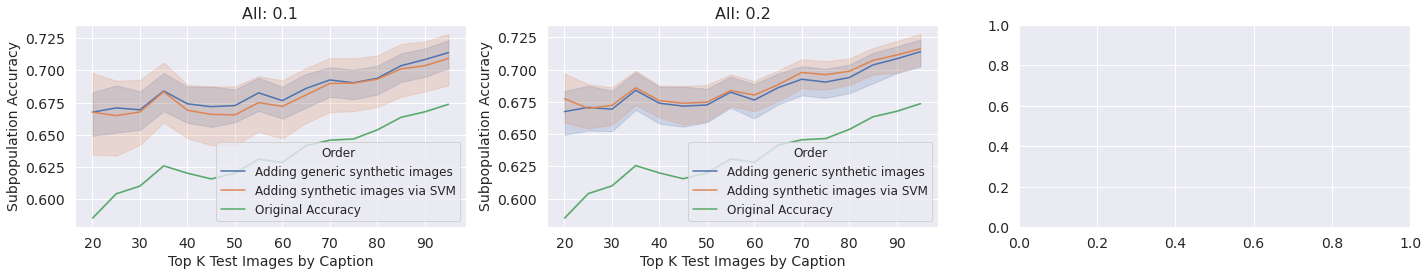

In [21]:
def get_dv_indices(target_c):
    dv = big_clip_dv
    mask = test_class == target_c
    inds = np.arange(len(dv))[mask]
    return inds[np.argsort(dv[mask])]

fig, ax_ = plt.subplots(1, 3, figsize=(20, 4))
cls = -1
trials = len(flip_int_corrects[0])
for intensity_idx, intensity in enumerate([0.1, 0.2]):
    ax = ax_[intensity_idx]
    load_corrects = {
        'flip': flip_int_corrects[intensity],
        'base': flip_int_corrects[0],
        'baseline': [torch.tensor(test_correct == 1) for _ in range(trials)],

    }
    print(torch.stack(load_corrects['flip']).float().mean(), torch.stack(load_corrects['base']).float().mean())

    K = 100


    all_dfs = []
    # valid_classes = np.arange(10)
    if cls == -1:
        valid_classes = np.arange(10)
    else:
        valid_classes = [cls]
    for v in range(trials):
        xaxis = np.arange(20, 100, 5)
        accs = {k:[] for k in load_corrects.keys()}
        for K in xaxis:
#             minority_indices = np.concatenate([get_dv_indices(target_c)[:K] for target_c in valid_classes])
            minority_indices = np.concatenate([saved_caption_and_most_relevant_imgs[(target_c, 0, 'neg')][0][:K] for target_c in valid_classes])
            for k in load_corrects.keys():
                accs[k].append(load_corrects[k][v][minority_indices].float().mean().item())
        df = pd.DataFrame()
        df['Top K'] = xaxis
        df['Adding generic synthetic images'] = accs['base']
        df['Adding synthetic images via SVM'] = accs['flip']
        df['Original Accuracy'] = accs['baseline']
        df = df.melt('Top K', var_name='Order', value_name='Subpopulation Accuracy')
        all_dfs.append(df)


    all_df = pd.concat(all_dfs).reset_index()

    sns.lineplot(data=all_df, x='Top K', y='Subpopulation Accuracy', hue='Order', ax=ax)
    ax.set_xlabel("Top K Test Images by Caption")
    t = 'All' if cls == -1 else cifar_label_list[cls]  
    ax.set_title(f'{t}: {intensity}')
plt.tight_layout()
plt.show()


In [34]:
df

,Top K,Order,Subpopulation Accuracy
0,20,Adding generic synthetic images,0.470000
1,25,Adding generic synthetic images,0.468000
2,30,Adding generic synthetic images,0.473333
3,35,Adding generic synthetic images,0.488571
4,40,Adding generic synthetic images,0.497500
5,45,Adding generic synthetic images,0.497778
6,50,Adding generic synthetic images,0.500000
7,55,Adding generic synthetic images,0.514545
8,60,Adding generic synthetic images,0.526667
9,65,Adding generic synthetic images,0.535385


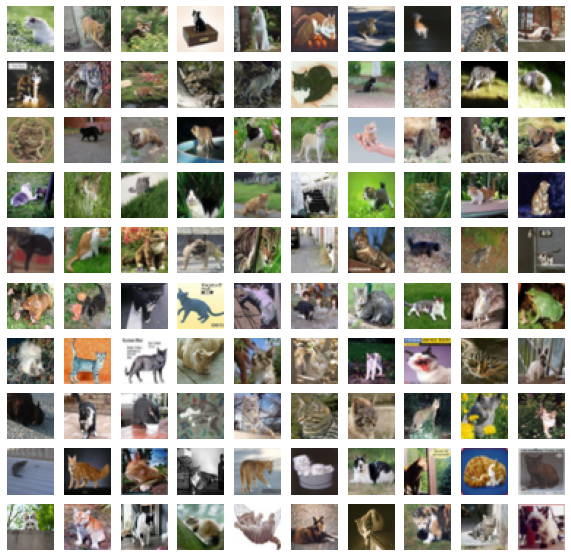

In [52]:
tds = torchvision.datasets.CIFAR10(ds_root, train=False)

fig, ax = plt.subplots(10, 10, figsize=(10, 10))
ax_ = ax.flatten()
for i in range(len(ax_)):
    ax_[i].imshow(tds[minority_indices[i]][0])
    ax_[i].grid(False)
    ax_[i].axis(False)
plt.show()

In [11]:
# See relative accuracies
flip_interventions = {}
for intensity in [0, 0.1, 0.2, 0.3]:
    base_synth_dataset = DiffDataset(path_dict, flip_name='flip', intensity=intensity, num_imgs_per_class=100,
                                     transform=resize_train_transform)
    synth_train_set = torch.utils.data.ConcatDataset([train_ds, base_synth_dataset])
    synth_train_loader = torch.utils.data.DataLoader(synth_train_set, batch_size=bsz, shuffle=True, drop_last=True)
    flip_interventions[intensity] = [
        run_finetune_model(synth_train_loader, val_loader, test_loader, set_device=True)
        for _ in range (1)
    ]

In [54]:
# See relative accuracies
flip_interventions = {}
for intensity in [0, 0.1, 0.2, 0.3]:
    base_synth_dataset = DiffDataset(path_dict, flip_name='flip', intensity=intensity, num_imgs_per_class=100,
                                     transform=resize_train_transform)
    synth_train_set = torch.utils.data.ConcatDataset([train_ds, base_synth_dataset])
    synth_train_loader = torch.utils.data.DataLoader(synth_train_set, batch_size=bsz, shuffle=True, drop_last=True)
    flip_interventions[intensity] = [
        run_model(synth_train_loader, val_loader, test_loader, set_device=True)
        for _ in range (1)
    ]

KeyboardInterrupt: 

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


100%|██████████| 300/300 [00:05<00:00, 56.72it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(source

consistent with old results 1.0
excluding bedlington terrier
excluding malamute
excluding smooth-haired fox terrier
excluding flat-coated retriever
excluding black-and-tan coonhound
excluding black-and-tan coonhound
excluding wire-haired fox terrier
excluding plott hound
excluding clumber
excluding liver-spotted dalmatian
excluding american staffordshire terrier
excluding sennenhunde
excluding blenheim spaniel
excluding staffordshire bullterrier
excluding staffordshire bullterrier
excluding belgian sheepdog
excluding lapdog
excluding doberman
excluding weimaraner
excluding ibizan hound
excluding appenzeller
excluding leonberg
excluding seizure-alert dog
excluding german short-haired pointer
excluding rottweiler
excluding pekinese
excluding norwich terrier
excluding curly-coated retriever
excluding great pyrenees
excluding old english sheepdog
excluding entlebucher
excluding brabancon griffon
excluding coondog
excluding shetland sheepdog
excluding soft-coated wheaten terrier
excluding b

100%|██████████| 11/11 [00:00<00:00, 161.91it/s]

dog
bird
automobile
airplane
truck
ship
frog
cat
horse
deer
reference
0.6642218046323067
performing classify captions on svm



100%|██████████| 1/1 [00:00<00:00, 110.88it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

{'neg_captions': array(['a photo of a red bomber', 'a photo of a red bomber inside',
       'a photo of a red reconnaissance plane inside',
       'a photo of a red bomber in the air',
       'a photo of a red reconnaissance plane',
       'a photo of a red bomber flying',
       'a photo of a red bomber outside',
       'a photo of a red reconnaissance plane outside',
       'a photo of a red dive bomber inside',
       'a photo of a red dive bomber'], dtype='<U62'),
 'neg_latents': array([[ 0.4033203 ,  0.3310547 ,  0.12005615, ..., -0.29614258,
        -0.16247559, -0.15063477],
       [ 0.17163086,  0.28735352, -0.00491714, ..., -0.13024902,
        -0.01203918, -0.10223389],
       [ 0.08837891,  0.19189453,  0.06976318, ...,  0.16992188,
         0.11950684, -0.14941406],
       ...,
       [ 0.18774414,  0.22155762,  0.19665527, ...,  0.11187744,
         0.05444336, -0.15112305],
       [ 0.22802734, -0.00438309, -0.09326172, ...,  0.24707031,
         0.25146484,  0.05679321],

100%|██████████| 1/1 [00:00<00:00, 104.98it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a ambulance', 'a photo of a ambulance outside',
       'a photo of a ambulance inside', 'a photo of a ambulance parked',
       'a photo of a brown ambulance inside',
       'a photo of a brown ambulance outside',
       'a photo of a brown ambulance',
       'a photo of a white ambulance inside',
       'a photo of a white ambulance outside', 'a photo of a stock car'],
      dtype='<U60'),
 'neg_latents': array([[ 0.12438965,  0.26489258,  0.05358887, ..., -0.42651367,
        -0.22302246, -0.23632812],
       [ 0.04193115,  0.35375977,  0.12487793, ..., -0.42138672,
        -0.19482422, -0.1809082 ],
       [ 0.02941895,  0.22436523, -0.01295471, ..., -0.36132812,
        -0.04232788, -0.23461914],
       ...,
       [-0.04595947,  0.05499268,  0.15649414, ..., -0.2631836 ,
        -0.17602539, -0.4020996 ],
       [-0.03607178,  0.14196777,  0.24609375, ..., -0.27441406,
        -0.25610352, -0.37060547],
       [-0.00428391,  0.12756348, -0.25073

100%|██████████| 1/1 [00:00<00:00, 133.09it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a white oscine inside',
       'a photo of a white twitterer inside',
       'a photo of a white twitterer flying',
       'a photo of a honey guide inside',
       'a photo of a orange twitterer inside',
       'a photo of a white honey guide inside',
       'a photo of a twitterer flying',
       'a photo of a white oscine in the air',
       'a photo of a red twitterer inside', 'a photo of a cackler inside'],
      dtype='<U65'),
 'neg_latents': array([[-0.19812012,  0.35253906, -0.18237305, ..., -0.22497559,
        -0.00176239, -0.14990234],
       [-0.19262695, -0.24230957, -0.13208008, ..., -0.28979492,
        -0.1194458 ,  0.04562378],
       [ 0.20727539,  0.26586914, -0.18103027, ..., -0.27563477,
         0.1315918 , -0.5126953 ],
       ...,
       [ 0.0612793 ,  0.29370117, -0.21142578, ..., -0.28149414,
         0.0871582 , -0.5449219 ],
       [-0.1829834 , -0.08105469, -0.21484375, ..., -0.34960938,
        -0.05825806,  0.2932129 ],

100%|██████████| 1/1 [00:00<00:00, 106.17it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a white mouser on the grass',
       'a photo of a blue mouser on the grass',
       'a photo of a white ocelot on the grass',
       'a photo of a green mouser on the grass',
       'a photo of a blue ocelot on the grass',
       'a photo of a red mouser on the grass',
       'a photo of a white cougar on the grass',
       'a photo of a green cougar on the grass',
       'a photo of a blue cougar on the grass',
       'a photo of a white persian cat on the grass'], dtype='<U60'),
 'neg_latents': array([[-0.22460938, -0.33374023,  0.10137939, ..., -0.07196045,
        -0.24133301, -0.09991455],
       [-0.10229492, -0.3071289 ,  0.01446533, ..., -0.12573242,
        -0.2783203 ,  0.24780273],
       [-0.16906738, -0.4230957 , -0.13537598, ...,  0.3215332 ,
        -0.22241211,  0.01625061],
       ...,
       [ 0.05981445, -0.1048584 , -0.03503418, ..., -0.09448242,
        -0.08703613,  0.28955078],
       [ 0.02685547, -0.24157715, -0.04205322, ..

100%|██████████| 1/1 [00:00<00:00, 134.28it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a kob inside', 'a photo of a kob',
       'a photo of a sassaby', 'a photo of a white kob in the snow',
       'a photo of a kob in the snow', 'a photo of a white kob inside',
       'a photo of a sassaby inside',
       'a photo of a white sassaby in the snow',
       'a photo of a sassaby outside', 'a photo of a sassaby in the snow'],
      dtype='<U63'),
 'neg_latents': array([[-0.21325684,  0.21948242, -0.04556274, ..., -0.5048828 ,
        -0.13024902,  0.2397461 ],
       [-0.1430664 ,  0.2956543 ,  0.08148193, ..., -0.63916016,
        -0.24694824,  0.22277832],
       [-0.24768066,  0.00634003, -0.10797119, ..., -0.828125  ,
        -0.08276367, -0.27929688],
       ...,
       [-0.1796875 , -0.01174164,  0.03137207, ..., -0.6254883 ,
        -0.01927185, -0.93359375],
       [-0.24414062,  0.0927124 , -0.07055664, ..., -0.88378906,
        -0.09381104, -0.26635742],
       [-0.25317383,  0.02832031, -0.07012939, ..., -0.8955078 ,
         0.

100%|██████████| 1/1 [00:00<00:00, 125.26it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a black feist', 'a photo of a black feist outside',
       'a photo of a feist', 'a photo of a black mexican hairless inside',
       'a photo of a brown feist', 'a photo of a black mexican hairless',
       'a photo of a brown mexican hairless inside',
       'a photo of a black mexican hairless outside',
       'a photo of a black feist inside', 'a photo of a green feist'],
      dtype='<U69'),
 'neg_latents': array([[ 0.12158203, -0.13012695, -0.18444824, ..., -0.18847656,
        -0.08825684,  0.34472656],
       [ 0.17443848, -0.03068542, -0.17297363, ..., -0.11096191,
        -0.02459717,  0.29467773],
       [-0.04125977, -0.03536987, -0.18225098, ..., -0.43969727,
        -0.17810059,  0.35595703],
       ...,
       [ 0.01129913, -0.0259552 , -0.17626953, ...,  0.24804688,
         0.11456299, -0.08331299],
       [ 0.12573242, -0.21240234, -0.27001953, ..., -0.22253418,
        -0.08129883,  0.45117188],
       [ 0.014534  , -0.12512207, -0

100%|██████████| 1/1 [00:00<00:00, 117.17it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a agua', 'a photo of a agua inside',
       'a photo of a agua outside', 'a photo of a black agua inside',
       'a photo of a black agua', 'a photo of a black agua outside',
       'a photo of a brown agua', 'a photo of a brown agua inside',
       'a photo of a white agua inside',
       'a photo of a brown agua outside'], dtype='<U68'),
 'neg_latents': array([[-0.15551758,  0.38793945,  0.18383789, ..., -0.27148438,
         0.03216553,  0.05941772],
       [-0.22351074,  0.43310547,  0.1282959 , ..., -0.27783203,
         0.12469482, -0.04089355],
       [-0.17822266,  0.54785156,  0.14880371, ..., -0.26904297,
         0.12731934,  0.09912109],
       ...,
       [-0.05691528,  0.5541992 ,  0.08105469, ..., -0.26635742,
         0.05380249, -0.1352539 ],
       [-0.3310547 ,  0.39892578,  0.234375  , ..., -0.25219727,
         0.1451416 , -0.24023438],
       [ 0.01754761,  0.54296875,  0.04727173, ..., -0.20349121,
        -0.02075195, -0.1446

100%|██████████| 1/1 [00:00<00:00, 101.67it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a protohippus inside',
       'a photo of a blue eohippus inside', 'a photo of a blue eohippus',
       'a photo of a wild horse', 'a photo of a white eohippus inside',
       'a photo of a blue steed inside', 'a photo of a eohippus inside',
       'a photo of a blue tarpan inside',
       'a photo of a green eohippus inside', 'a photo of a protohippus'],
      dtype='<U63'),
 'neg_latents': array([[-0.19116211,  0.33618164, -0.37451172, ..., -0.17797852,
        -0.23901367, -0.25439453],
       [-0.3017578 ,  0.00455856, -0.09680176, ..., -0.07965088,
        -0.12585449,  0.171875  ],
       [-0.20568848,  0.07617188,  0.11871338, ...,  0.05502319,
        -0.10473633,  0.10803223],
       ...,
       [-0.19360352,  0.21838379,  0.0096817 , ..., -0.04486084,
        -0.46240234,  0.0647583 ],
       [-0.3527832 ,  0.09997559, -0.28759766, ..., -0.0567627 ,
         0.0411377 ,  0.2241211 ],
       [ 0.01934814,  0.4567871 , -0.28881836, ..., -0.15

100%|██████████| 1/1 [00:00<00:00, 100.83it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a racing gig', 'a photo of a blue racing gig outside',
       'a photo of a racing gig outside', 'a photo of a blue racing gig',
       'a photo of a racing gig inside',
       'a photo of a blue racing gig inside',
       'a photo of a blue sloop of war outside',
       'a photo of a white racing gig outside',
       'a photo of a blue racing gig on the horizon',
       'a photo of a blue sloop of war'], dtype='<U75'),
 'neg_latents': array([[ 0.2331543 ,  0.05691528,  0.03704834, ...,  0.11865234,
         0.07855225, -0.18457031],
       [ 0.1973877 ,  0.05496216,  0.03317261, ..., -0.02108765,
         0.10809326,  0.00676346],
       [ 0.19897461,  0.0034771 ,  0.03433228, ..., -0.0254364 ,
         0.21875   , -0.0423584 ],
       ...,
       [ 0.03034973,  0.02455139,  0.15991211, ..., -0.11199951,
         0.15441895, -0.2890625 ],
       [ 0.20385742, -0.01551056,  0.06518555, ...,  0.24902344,
         0.07141113,  0.07067871],
       [-0.1

100%|██████████| 1/1 [00:00<00:00, 142.05it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a white passenger van',
       'a photo of a white passenger van inside',
       'a photo of a white passenger van on the road',
       'a photo of a white passenger van outside',
       'a photo of a blue passenger van on the road',
       'a photo of a blue passenger van',
       'a photo of a brown passenger van on the road',
       'a photo of a blue passenger van inside',
       'a photo of a blue passenger van outside',
       'a photo of a orange passenger van on the road'], dtype='<U56'),
 'neg_latents': array([[ 0.0612793 ,  0.1538086 ,  0.15783691, ...,  0.25756836,
        -0.05764771, -0.17041016],
       [-0.0194397 ,  0.2244873 ,  0.05880737, ...,  0.19238281,
        -0.02528381, -0.18786621],
       [-0.0557251 ,  0.1685791 ,  0.14208984, ...,  0.25732422,
         0.01333618, -0.16625977],
       ...,
       [ 0.18969727,  0.10583496, -0.03022766, ...,  0.28515625,
        -0.11218262,  0.2331543 ],
       [ 0.26245117,  0.11224365, 

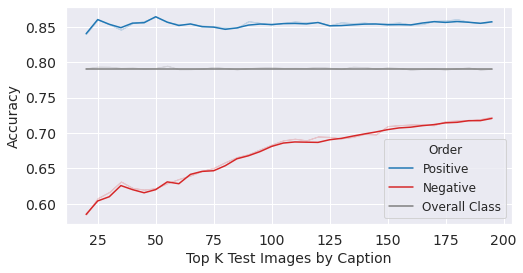

In [19]:
import src.clip_utils as clip_utils
cifar_label_list = np.array([CLASS_DICT['CIFAR'][u] for u in range(10)])

clip_analyzer = viz_utils.ClipAnalyzer(
    processor=processor, svm_model_name=svm_model_name, caption_set_name="CIFAR", class_names=cifar_label_list)

def get_cdf(arr, K_range=None):
    out = []
    if K_range is None:
        K_range = np.arange(10, len(arr), 10)
    for K in K_range:
        out.append(arr[:K].mean())
    out = np.array(out)
    return out, K_range

saved_caption_and_most_relevant_imgs = {}
all_dfs = []
for target_class in range(10):
    print(processor.metrics['cv_scores'][target_class])
    print("performing classify captions on svm")
    result = clip_analyzer.get_svm_style_top_K(target_class, 'all')
    print("--------")

    cdfs = {}
    class_mask = test_class==target_class
    masked_indices = np.arange(len(test_class))[class_mask]
    # K_range = np.arange(10, len(masked_indices), 10)
    K_range=np.arange(20, 200, 5)
    for caption_index in range(1):
        for direction in ['pos', 'neg']:
            caption_text = result[f'{direction}_captions'][caption_index]
            print(f"{direction}: {caption_text}")
            top_caption_latent = torch.tensor(result[f'{direction}_latents'][caption_index]).cuda()

            image_latents = clip_analyzer.clip_features['test'][class_mask].cuda()
            image_angles = clip_utils.order_descriptions_angle(mean_point=top_caption_latent.unsqueeze(0), query_points=image_latents)
            image_order = np.argsort(image_angles)[::-1]
            saved_caption_and_most_relevant_imgs[(target_class, caption_index, direction)] = (masked_indices[image_order], caption_text)
            dir_name = 'Positive' if direction == 'pos' else 'Negative' 
            cdfs[dir_name], _ = get_cdf(test_correct[masked_indices[image_order]], K_range)
            # uncomment this to display the images

        df = pd.DataFrame()
        df['Top K'] = K_range
        for d, v in cdfs.items():
            df[d] = v
        df['Overall Class'] = test_correct[masked_indices].mean()
        df = df.melt('Top K', var_name='Order', value_name='Accuracy')
        all_dfs.append(df)
    
combined_df = pd.concat(all_dfs).reset_index()
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.lineplot(data=combined_df, x='Top K', y='Accuracy', hue='Order', ax=ax, 
             hue_order=['Positive', 'Negative', 'Overall Class'], 
            palette=[BLUE, RED, GRAY], ci=False)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=labels)
ax.set_xlabel("Top K Test Images by Caption")
plt.show()
    

tensor(0.8023) tensor(0.8042)


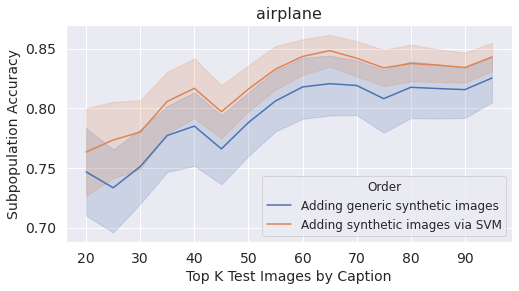

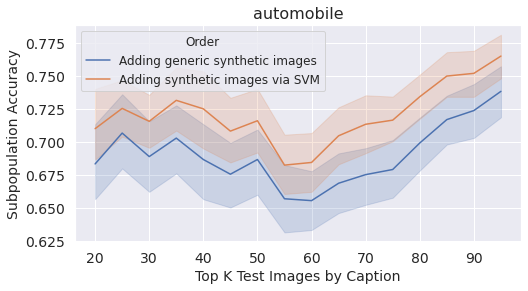

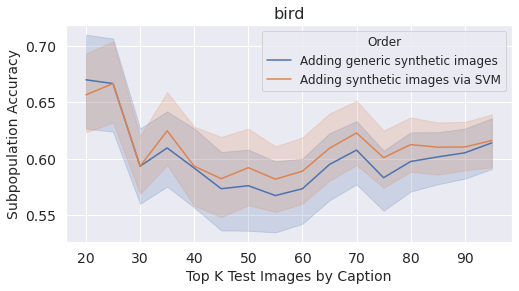

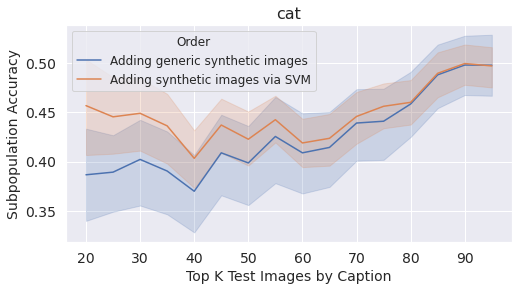

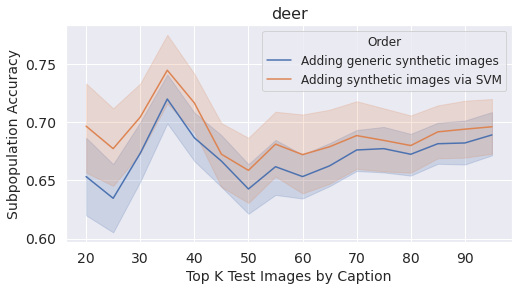

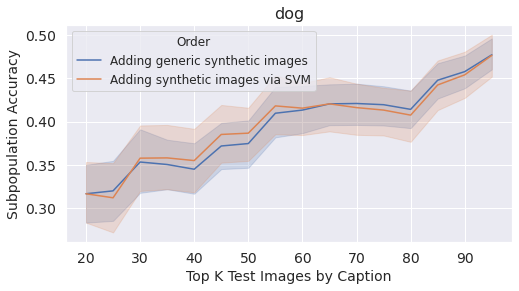

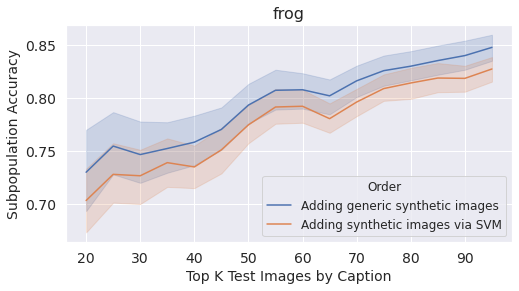

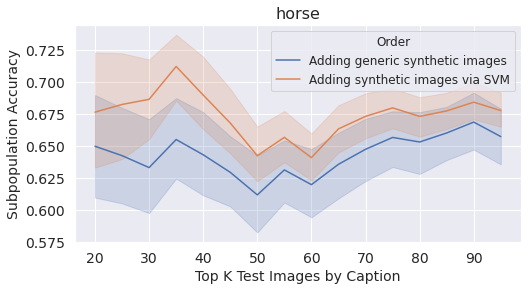

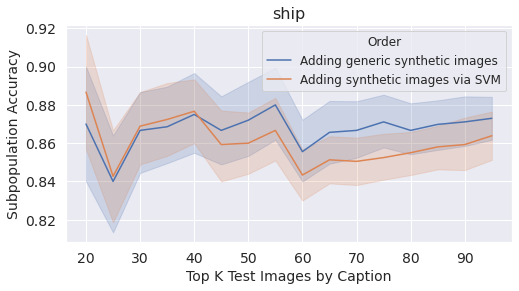

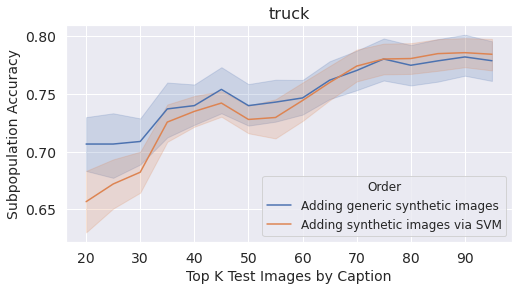

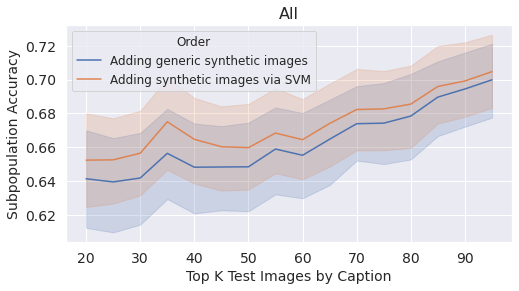

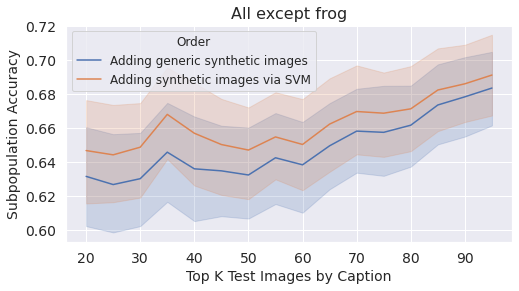

In [54]:
intensity = 0.1
load_corrects = {
    'flip': [(flip_interventions[intensity][u][0] == flip_interventions[intensity][u][1]) for u in range(len(flip_interventions[intensity]))],
    'base': [(flip_interventions[0][u][0] == flip_interventions[0][u][1]) for u in range(len(flip_interventions[0]))],
#     'none': [(no_intervention[u][0] == no_intervention[u][1]) for u in range(5)],

}
trials = len(flip_interventions[0])
print(torch.stack(load_corrects['flip']).float().mean(), torch.stack(load_corrects['base']).float().mean())

K = 100



#         print(cifar_label_list[target_class], base_accs[target_class], orig_accs[target_class])
all_dfs = []
for v in range(trials):
    dfs = []
    for target_c in np.arange(num_classes):
        xaxis = np.arange(20, 100, 5)
        indices, caption = saved_caption_and_most_relevant_imgs[(target_c, 0, 'neg')]
        base, _ = get_cdf(load_corrects['base'][v][indices].float(), xaxis)
        flip, _ = get_cdf(load_corrects[('flip')][v][indices].float(), xaxis)

        df = pd.DataFrame()
        df['Top K'] = xaxis
        df['Adding generic synthetic images'] = base
        df['Adding synthetic images via SVM'] = flip

        df = df.melt('Top K', var_name='Order', value_name='Subpopulation Accuracy')
        df['Class'] = target_c
        dfs.append(df)
    combined_df = pd.concat(dfs).reset_index()
    combined_df = combined_df.groupby(['Top K', 'Order', 'Class']).mean().reset_index()[['Top K', 'Order', 'Subpopulation Accuracy', 'Class']]
    all_dfs.append(combined_df)
    
def plot_sub_df(sub_df, title):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.lineplot(data=sub_df, x='Top K', y='Subpopulation Accuracy', hue='Order', ax=ax)
    ax.set_xlabel("Top K Test Images by Caption")
    ax.set_title(title)
    plt.show()
    
df = pd.concat(all_dfs).reset_index()
for target_class in np.arange(num_classes):
    plot_sub_df(df[df['Class'] == target_class], cifar_label_list[target_class])
plot_sub_df(df, "All")
plot_sub_df(df[df['Class'] != 6], "All except frog")
    

tensor(0.8023) tensor(0.8042)
tensor(0.7954) tensor(0.8042)
tensor(0.8014) tensor(0.8042)


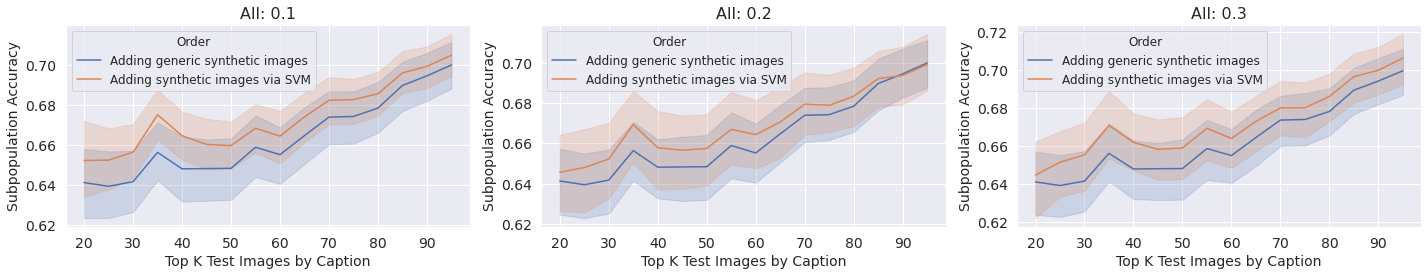

In [73]:
def get_dv_indices(target_c):
    mask = test_class == target_c
    inds = np.arange(len(big_clip_dv))[mask]
    return inds[np.argsort(big_clip_dv[mask])]

fig, ax_ = plt.subplots(1, 3, figsize=(20, 4))
cls = -1
if cls == -1:
    flip_interventions = torch.load("cifar10_sd_results.pt")
else:
    flip_interventions = torch.load(f"/mnt/cfs/home/saachij/src/failure-directions/failure_directions/cifar_sd_{cls}.pt")
for intensity_idx, intensity in enumerate([0.1, 0.2, 0.3]):
    ax = ax_[intensity_idx]
    load_corrects = {
        'flip': [(flip_interventions[intensity][u][0] == flip_interventions[intensity][u][1]) for u in range(len(flip_interventions[intensity]))],
        'base': [(flip_interventions[0][u][0] == flip_interventions[0][u][1]) for u in range(len(flip_interventions[0]))],
    #     'none': [(no_intervention[u][0] == no_intervention[u][1]) for u in range(5)],

    }
    trials = len(flip_interventions[0])
    print(torch.stack(load_corrects['flip']).float().mean(), torch.stack(load_corrects['base']).float().mean())

    K = 100


    all_dfs = []
    # valid_classes = np.arange(10)
    if cls == -1:
        valid_classes = np.arange(10)
    else:
        valid_classes = [cls]
    for v in range(trials):
        xaxis = np.arange(20, 100, 5)
        base, flip = [], []
        for K in xaxis:
#             minority_indices = np.concatenate([get_dv_indices(target_c)[:K] for target_c in valid_classes])
            minority_indices = np.concatenate([saved_caption_and_most_relevant_imgs[(target_c, 0, 'neg')][0][:K] for target_c in valid_classes])
            base.append(load_corrects['base'][v][minority_indices].float().mean().item())
            flip.append(load_corrects[('flip')][v][minority_indices].float().float().mean().item())
        df = pd.DataFrame()
        df['Top K'] = xaxis
        df['Adding generic synthetic images'] = base
        df['Adding synthetic images via SVM'] = flip
        df = df.melt('Top K', var_name='Order', value_name='Subpopulation Accuracy')
        all_dfs.append(df)


    all_df = pd.concat(all_dfs).reset_index()

    sns.lineplot(data=all_df, x='Top K', y='Subpopulation Accuracy', hue='Order', ax=ax)
    ax.set_xlabel("Top K Test Images by Caption")
    t = 'All' if cls == -1 else cifar_label_list[cls]  
    ax.set_title(f'{t}: {intensity}')
plt.tight_layout()
plt.show()


In [62]:
sub_df

,index,Top K,Order,Subpopulation Accuracy,Class
9,9,20,Adding generic synthetic images,0.700000,9
19,19,20,Adding synthetic images via SVM,0.750000,9
29,29,25,Adding generic synthetic images,0.720000,9
39,39,25,Adding synthetic images via SVM,0.760000,9
49,49,30,Adding generic synthetic images,0.733333,9
...,...,...,...,...,...
4759,279,85,Adding synthetic images via SVM,0.823529,9
4769,289,90,Adding generic synthetic images,0.833333,9
4779,299,90,Adding synthetic images via SVM,0.822222,9
4789,309,95,Adding generic synthetic images,0.831579,9


In [52]:
df

,index,Top K,Order,Subpopulation Accuracy,Class
0,0,20,Adding generic synthetic images,0.800000,0
1,1,20,Adding generic synthetic images,0.700000,1
2,2,20,Adding generic synthetic images,0.650000,2
3,3,20,Adding generic synthetic images,0.350000,3
4,4,20,Adding generic synthetic images,0.650000,4
...,...,...,...,...,...
4795,315,95,Adding synthetic images via SVM,0.589474,5
4796,316,95,Adding synthetic images via SVM,0.852632,6
4797,317,95,Adding synthetic images via SVM,0.694737,7
4798,318,95,Adding synthetic images via SVM,0.915789,8


In [65]:
clip_analyzer.captions['reference']

['a photo of a airplane',
 'a photo of a automobile',
 'a photo of a bird',
 'a photo of a cat',
 'a photo of a deer',
 'a photo of a dog',
 'a photo of a frog',
 'a photo of a horse',
 'a photo of a ship',
 'a photo of a truck']

In [13]:
out = torch.load("synth_model_results.pt")

In [14]:
no_intervention = out['no_intervention']
flip_interventions = out['flip_intervention']
base_intervention = out['base_intervention']

In [81]:
no_intervention

[(tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.9736, 0.9980, 0.9996,  ..., 0.9998, 0.9998, 0.9724])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.8502, 0.9268, 0.9994,  ..., 0.9996, 0.9960, 0.9489])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.7708, 0.9999, 1.0000,  ..., 0.9988, 0.9972, 0.9987])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.6072, 0.9871, 0.9984,  ..., 0.9992, 0.9999, 0.9983])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.8949, 0.9939, 0.9277,  ..., 0.9601, 0.8612, 0.9952]))]

In [ ]:
out = np.load("/mnt/nfs/projects/data-transfer/mturk_target_groupings/infl_values.npy")

In [ ]:
imagenet_label_list = np.array([CLASS_DICT['ImageNet'][u].split(',')[0] for u in range(1000)])